In [1]:
import requests
import json
def request_tle(year, month, date, hours, norad_id):
    """
    request tle from api server.
    """
    server_url = "https://platformapi.spacemap42.com"
    # SEVERURL = "http://localhost:8082"
    url = f"{server_url}/tles/{year:02d}/{month:02d}/{date:02d}/{hours:02d}?id={norad_id}"
    response = requests.get(url)
    result = json.loads(response.text)
    # print(result)
    return result["data"]["tles"][0]

In [2]:
from datetime import datetime, timedelta
now = datetime.now()
year = now.year
month = now.month
date = now.day
hours = 0
tles = request_tle(year, month, date, 0, 58400)

In [3]:
import sgp4
from sgp4.api import Satrec, WGS72
from sgp4.conveniences import jday
from sgp4.ext import invjday

satellite = Satrec.twoline2rv(tles["firstLine"], tles["secondLine"])
jd, fr =jday(year, month, date, hours, 0, 0)
e, position, velocity = satellite.sgp4(jd, fr)
print(position)

(6856.511364144375, 480.91851722594413, -334.6745913764961)


In [109]:
# Orbit Height (apogee, perigee)
# Orbit Velocity
# Orbit Inclination
# Orbit RAAN
apogees = dict()
perigees = dict()
average_altitudes = dict()
average_velocities = dict()
inclinations = dict()
eccentricities = dict()
RAANs = dict()
epoch = datetime(2023, 11, 22, 0, 0, 0)

while(epoch < datetime.now()):
    print(epoch)
    try:
        year = epoch.year
        month = epoch.month
        date = epoch.day
        jd, fr =jday(year, month, date, 0, 0, 0)
        tle = request_tle(year, month, date, 0, 58400)
        print(tle)
        satellite = Satrec.twoline2rv(tle["firstLine"], tle["secondLine"])
        jdsatepoch = satellite.jdsatepoch
        jdsatepochfrac = satellite.jdsatepochF
        average_altitude = 0
        average_velocity = 0
        for i in range(1440):
            jd = jdsatepoch
            fr = jdsatepochfrac + i/1440
            e, position, velocity = satellite.sgp4(jd, fr)
            average_altitude += (position[0]**2 + position[1]**2 + position[2]**2)**0.5
            average_velocity += (velocity[0]**2 + velocity[1]**2 + velocity[2]**2)**0.5
        average_altitude /= 1440
        average_velocity /= 1440
        earth_radius = 6378.137
        epochdatetime = invjday(jdsatepoch + jdsatepochfrac)
        apogees[epochdatetime] = satellite.alta * earth_radius
        perigees[epochdatetime] = satellite.altp * earth_radius
        average_altitudes[epochdatetime] = average_altitude - earth_radius
        average_velocities[epochdatetime] = average_velocity
        # velocities.append((velocity[0]**2 + velocity[1]**2 + velocity[2]**2)**0.5)
        rad2deg = 180.0 / 3.141592653589793
        inclinations[epochdatetime] = satellite.inclo*rad2deg
        eccentricities[epochdatetime] = satellite.ecco
        RAANs[epochdatetime] = satellite.nodeo
    except Exception as e:
        print(e)
        # apogees.append(None)
        # perigees.append(None)
        # average_altitudes.append(None)
        # average_velocities.append(None)
        # inclinations.append(None)
        # eccentricities.append(None)
        # RAANs.append(None)
        pass
    epoch += timedelta(days=1)
print(apogees)
    

2023-11-22 00:00:00
list index out of range
2023-11-23 00:00:00
{'name': 'MALLIGYONG-1', 'firstLine': '1 58400U 23179A   23326.16510777  .00018821  00000-0  84547-3 0  9990', 'secondLine': '2 58400  97.4263 210.9434 0014062 277.7388 210.8950 15.21112775    83'}
2023-11-24 00:00:00
{'name': 'MALLIGYONG-1', 'firstLine': '1 58400U 23179A   23327.85194839  .00009066  00000-0  40904-3 0  9994', 'secondLine': '2 58400  97.4277 212.6030 0014293 271.9299  88.0300 15.21142738   347'}
2023-11-25 00:00:00
{'name': 'MALLIGYONG-1', 'firstLine': '1 58400U 23179A   23328.83867352  .00009555  00000-0  43066-3 0  9995', 'secondLine': '2 58400  97.4277 213.5763 0014276 268.0864  91.8737 15.21162102   495'}
2023-11-26 00:00:00
{'name': 'MALLIGYONG-1', 'firstLine': '1 58400U 23179A   23329.23335983  .00010902  00000-0  49070-3 0  9999', 'secondLine': '2 58400  97.4278 213.9656 0014261 266.5490  93.4115 15.21172069   551'}
2023-11-27 00:00:00
{'name': 'MALLIGYONG-1', 'firstLine': '1 58400U 23179A   23330.6

In [110]:
#sort by date
apogees = dict(sorted(apogees.items()))
perigees = dict(sorted(perigees.items()))
average_altitudes = dict(sorted(average_altitudes.items()))
average_velocities = dict(sorted(average_velocities.items()))
inclinations = dict(sorted(inclinations.items()))
eccentricities = dict(sorted(eccentricities.items()))
RAANs = dict(sorted(RAANs.items()))

In [172]:
print(len(apogees.keys()))

150


In [187]:
def draw_graph(data, title, ylabel, color="blue"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    formatted_dates = [f"{date[0]}-{date[1]}-{date[2]}" for date in data.keys()]
    plt.plot(formatted_dates, data.values(), color=color)
    plt.title(title)
    # plt.ylabel(ylabel, fontsize=12)
    # plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)

    for i, date in enumerate(formatted_dates):
        if date == "2024-2-19":
            plt.axvline(x=i, color="red", linestyle="--")
        if date == "2024-2-24":
            plt.axvline(x=i, color="red", linestyle="--")
    
    ylim_min = min(data.values()) - (max(data.values()) - min(data.values())) * 0.1
    ylim_max = max(data.values()) + (max(data.values()) - min(data.values())) * 0.1
    plt.ylim(ylim_min, ylim_max)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.show()

def draw_altitudes(apogees, perigees, average_altitudes):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    formatted_dates = [f"{date[0]}-{date[1]}-{date[2]}" for date in apogees.keys()]
    plt.plot(formatted_dates, apogees.values(), color="blue", label="apogee")
    plt.plot(formatted_dates, perigees.values(), color="red", label="perigee")
    plt.plot(formatted_dates, average_altitudes.values(), color="green", label="average altitude")
    # plt.title("Orbit Height")
    plt.legend()
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    all_data = list(apogees.values()) + list(perigees.values()) + list(average_altitudes.values())
    ylim_min = min(all_data) - (max(all_data) - min(all_data)) * 0.2
    ylim_max = max(all_data) + (max(all_data) - min(all_data)) * 0.2
    plt.ylim(ylim_min, ylim_max)
    for i, date in enumerate(formatted_dates):
        if date == "2024-2-19":
            plt.axvline(x=i, color="red", linestyle="--")
        if date == "2024-2-24":
            plt.axvline(x=i, color="red", linestyle="--")
    
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.show()

In [170]:
def print_statistics(data):
    print("min:", min(data.values()))
    print("max:", max(data.values()))
    print("average:", sum(data.values())/len(data.values()))
    print("median:", sorted(data.values())[len(data.values())//2])
    print("standard deviation:", (sum([(value - sum(data.values())/len(data.values()))**2 for value in data.values()])/len(data.values()))**0.5)
    print("variance:", (sum([(value - sum(data.values())/len(data.values()))**2 for value in data.values()])/len(data.values())))
    print("range:", max(data.values()) - min(data.values()))

In [171]:
print("Apogees")
print_statistics(apogees)
print("Perigees")
print_statistics(perigees)
print("Average Altitudes")
print_statistics(average_altitudes)
print("Average Velocities")
print_statistics(average_velocities)
print("Inclinations")
print_statistics(inclinations)
print("Eccentricities")
print_statistics(eccentricities)
print("RAANs")
print_statistics(RAANs)


Apogees
min: 504.1632500658107
max: 509.3882678326941
average: 506.8164375395349
median: 507.2452877389935
standard deviation: 2.0916540135772697
variance: 4.3750165125139
range: 5.225017766883411
Perigees
min: 484.6152660982959
max: 493.72370770876915
average: 488.4801929613032
median: 488.68605181501846
standard deviation: 3.002995012050871
variance: 9.01797904240241
range: 9.108441610473278
Average Altitudes
min: 499.81121708867886
max: 503.98658793041886
average: 502.15023795318945
median: 502.24775244426655
standard deviation: 1.1158913849746643
variance: 1.2452135830606743
range: 4.175370841740005
Average Velocities
min: 7.6079046154179295
max: 7.610259770257905
average: 7.608937399283158
median: 7.608871720660345
standard deviation: 0.0006582811624586431
variance: 4.3333408884790246e-07
range: 0.002355154839975171
Inclinations
min: 97.4107
max: 97.4278
average: 97.42105600000001
median: 97.4229
standard deviation: 0.005149504571638765
variance: 2.6517397333328542e-05
range: 0.01

In [173]:
def find_max_key(data):
    max_key = None
    max_value = 0
    for key, value in data.items():
        if value > max_value:
            max_key = key
            max_value = value
    return max_key

In [174]:
print(find_max_key(perigees))

(2024, 2, 26, 19, 13, 19.972714483073972)


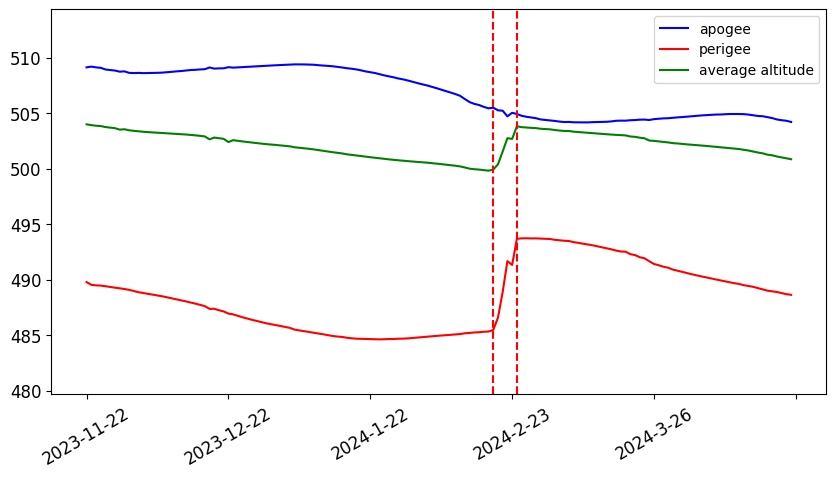

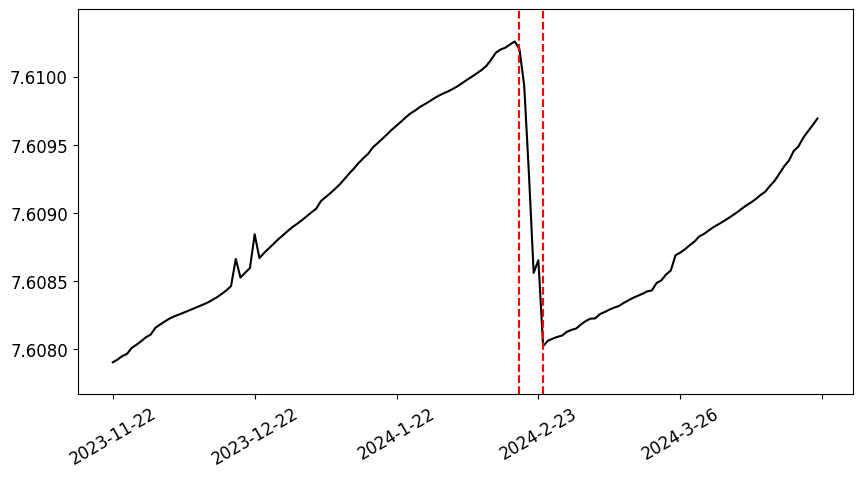

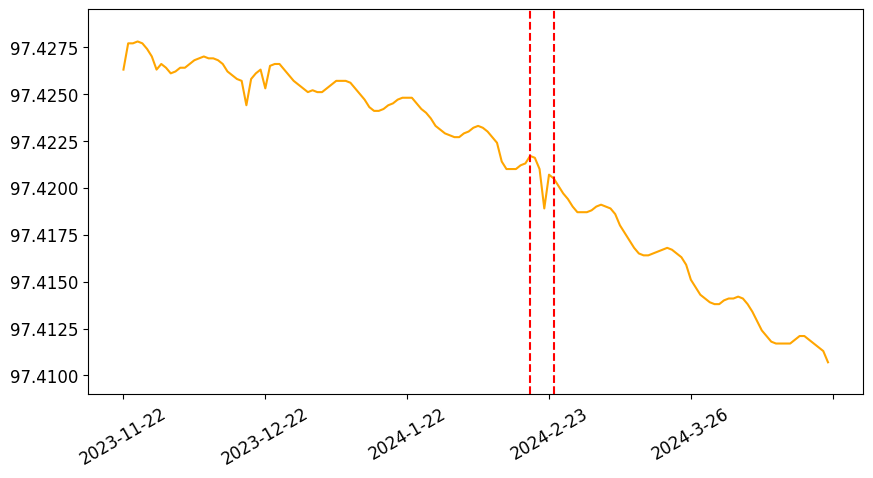

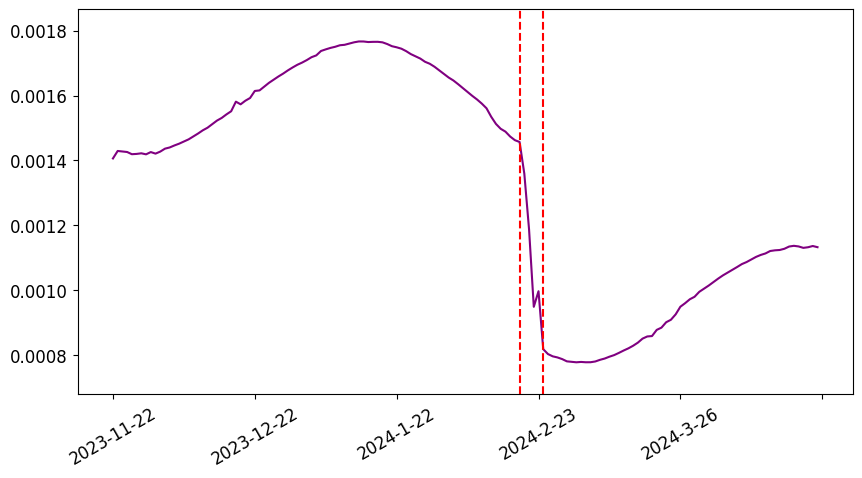

In [188]:
draw_altitudes(apogees, perigees, average_altitudes)
draw_graph(average_velocities,'','', "black")
draw_graph(inclinations, '','', 'orange')
draw_graph(eccentricities, '','','purple')

In [ ]:
def draw_graph(x_ticks, data, title, ylabel, color="blue"):
    import matplotlib.pyplot as plt
    #set ratio
    plt.figure(figsize=(10, 5))
    plt.plot(data, color=color)
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.title(title)
    # set y limit
    data_max = max(data)
    data_min = min(data)
    lim_max = data_max + (data_max - data_min) * 0.5
    lim_min = data_min - (data_max - data_min) * 0.5
    plt.ylim(lim_min, lim_max)
    # write y ticks
    # fine_y_ticks = [lim_min + (lim_max - lim_min) * i / 5 for i in range(6)]
    # # y format is 0.0e+00, so convert to 0.0
    # fine_y_ticks = [f"{tick:.2f}" for tick in fine_y_ticks]
    # plt.yticks(fine_y_ticks)
    # coarsen x ticks
    # format x ticks to write only date
    x_ticks = [f"{tick.month:02d}-{tick.day:02d}" for tick in x_ticks]
    plt.xticks(range(len(x_ticks)), x_ticks, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    # set xticks bold
    
    # x major ticks
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.ylabel(ylabel)
    # plt.xlabel("Date")
    
    plt.show()
    
    
def draw_altitudes(x_ticks, apogees, perigees, average_altitude, title, ylabel):
    import matplotlib.pyplot as plt
    # plot three lines
    plt.figure(figsize=(10, 5))
    plt.plot(apogees, label="Apogee", color="red")
    plt.plot(perigees, label="Perigee", color="blue")
    plt.plot(average_altitude, label="Average altitude (24h)", color="green")
    plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
    plt.title(title)
    # set y limit
    total_data = apogees + perigees + average_altitude
    data_max = max(total_data)
    data_min = min(total_data)
    lim_max = data_max + (data_max - data_min) * 0.5
    lim_min = data_min - (data_max - data_min) * 0.5
    plt.ylim(lim_min, lim_max)
    # write y ticks
    # fine_y_ticks = [lim_min + (lim_max - lim_min) * i / 5 for i in range(6)]
    # # y format is 0.0e+00, so convert to 0.0
    # fine_y_ticks = [f"{tick:.2f}" for tick in fine_y_ticks]
    # plt.yticks(fine_y_ticks)
    # coarsen x ticks
    # format x ticks to write only date
    x_ticks = [f"{tick.month:02d}-{tick.day:02d}" for tick in x_ticks]
    plt.xticks(range(len(x_ticks)), x_ticks, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    # x major ticks
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.ylabel(ylabel)
    plt.legend()
    
    plt.show()
    